In [1]:
# Importar librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configurar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

Usando device: cuda


In [2]:
# Cargar dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, 
                              download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Dataset cargado: {len(train_dataset)} imágenes")

Dataset cargado: 60000 imágenes


In [3]:
def get_noise_schedule(timesteps=1000):
    beta_start = 0.0001
    beta_end = 0.02
    
    betas = torch.linspace(beta_start, beta_end, timesteps)
    
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    return betas, alphas, alphas_cumprod

timesteps = 1000
betas, alphas, alphas_cumprod = get_noise_schedule(timesteps)

print(f"Cronograma de ruido configurado para {timesteps} pasos")

Cronograma de ruido configurado para 1000 pasos


In [4]:
def forward_diffusion(x0, t, alphas_cumprod):
    batch_size = x0.shape[0]
    
    noise = torch.randn_like(x0)
    
    alpha_cumprod_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    
    x_t = torch.sqrt(alpha_cumprod_t) * x0 + torch.sqrt(1 - alpha_cumprod_t) * noise
    
    return x_t, noise

x_sample, _ = next(iter(train_loader))
x_sample = x_sample[:4]
t_sample = torch.randint(0, timesteps, (4,))

x_noisy, noise_true = forward_diffusion(x_sample, t_sample, alphas_cumprod)
print(f"Proceso forward probado - Forma de entrada: {x_sample.shape}, Forma con ruido: {x_noisy.shape}")

Proceso forward probado - Forma de entrada: torch.Size([4, 1, 28, 28]), Forma con ruido: torch.Size([4, 1, 28, 28])


In [5]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128, num_classes=10):
        super(ConditionalUNet, self).__init__()
        
        # tamaño del embedding temporal(time embedding)
        self.time_emb_dim = time_emb_dim
        
        # MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        
        self.num_classes = num_classes + 1
        
        # Crea un embedding para cada clase textual
        self.class_emb = nn.Embedding(self.num_classes, time_emb_dim)
        
        # Fusiona tiempo + clase en un solo vector
        self.context_mlp = nn.Sequential(
            nn.Linear(time_emb_dim * 2, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim)
        )
        
        # Encoder(4 etapas del encoder)
        self.enc1 = self._make_layer(in_channels, 64, time_emb_dim)
        self.enc2 = self._make_layer(64, 128, time_emb_dim) 
        self.enc3 = self._make_layer(128, 256, time_emb_dim)
        self.enc4 = self._make_layer(256, 512, time_emb_dim)
        
        # Bottleneck
        self.bottleneck = self._make_layer(512, 1024, time_emb_dim)
        
        # Decoder con skip connections(4 etapas del decoder)
        self.dec1 = self._make_layer(1024 + 512, 512, time_emb_dim)
        self.dec2 = self._make_layer(512 + 256, 256, time_emb_dim) 
        self.dec3 = self._make_layer(256 + 128, 128, time_emb_dim)
        self.dec4 = self._make_layer(128 + 64, 64, time_emb_dim)
        
        # Output layer
        self.final = nn.Conv2d(64, out_channels, 1)
        
        # Pooling y upsampling
        self.pool = nn.MaxPool2d(2) # Reduce la imagen a la mitad
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # Aumenta el tamaño al doble
        
    # Crea un bloque e red
    def _make_layer(self, in_ch, out_ch, time_emb_dim):
        return nn.ModuleDict({
            'conv1': nn.Conv2d(in_ch, out_ch, 3, padding=1),
            'norm1': nn.GroupNorm(8, out_ch),
            'conv2': nn.Conv2d(out_ch, out_ch, 3, padding=1), 
            'norm2': nn.GroupNorm(8, out_ch),
            'time_proj': nn.Linear(time_emb_dim, out_ch), # para inyectar el embedding en cada bloque
            'act': nn.SiLU()
        })
    
    # Aplica el contexto a cada bloque
    def _forward_layer(self, x, context_emb, layer):
        h = layer['act'](layer['norm1'](layer['conv1'](x))) # Procesa la imagen con la primera convolucion
        
        # Inyecta el embedding de contexto
        context_proj = layer['time_proj'](context_emb)
        context_proj = context_proj.unsqueeze(-1).unsqueeze(-1)
        h = h + context_proj
        
        h = layer['act'](layer['norm2'](layer['conv2'](h))) # Se refina la informacion en la segunda convolucion
        
        return h
    
    # COnvierte un timestep en un vector con seno y coseno para capturar posiciciones
    def get_time_embedding(self, timesteps):
        half_dim = self.time_emb_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb
    
    def forward(self, x, t, class_labels=None):
        t_emb = self.get_time_embedding(t.float()) 
        t_emb = self.time_mlp(t_emb)
        
        if class_labels is not None:
            c_emb = self.class_emb(class_labels)
        else:
            null_class = torch.full((x.shape[0],), self.num_classes - 1, device=x.device)
            c_emb = self.class_emb(null_class)
        
        context_emb = torch.cat([t_emb, c_emb], dim=1)
        context_emb = self.context_mlp(context_emb)
        
        e1 = self._forward_layer(x, context_emb, self.enc1)
        e2 = self._forward_layer(self.pool(e1), context_emb, self.enc2) 
        e3 = self._forward_layer(self.pool(e2), context_emb, self.enc3)
        e4 = self._forward_layer(self.pool(e3), context_emb, self.enc4)
        
        b = self._forward_layer(self.pool(e4), context_emb, self.bottleneck)
        
        d1 = self.up(b)
        d1 = nn.functional.interpolate(d1, size=e4.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self._forward_layer(d1, context_emb, self.dec1)
        
        d2 = self.up(d1)
        d2 = nn.functional.interpolate(d2, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self._forward_layer(d2, context_emb, self.dec2)
        
        d3 = self.up(d2)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self._forward_layer(d3, context_emb, self.dec3)
        
        d4 = self.up(d3)
        d4 = torch.cat([d4, e1], dim=1) 
        d4 = self._forward_layer(d4, context_emb, self.dec4)
        
        out = self.final(d4)
        
        return out

conditional_model = ConditionalUNet().to(device)
total_params = sum(p.numel() for p in conditional_model.parameters())
print(f"Modelo CONDICIONAL creado con {total_params:,} parámetros")

print("Copiando pesos del modelo incondicional (Transfer Learning)...")
try:
    old_state_dict = model.state_dict()
    new_state_dict = conditional_model.state_dict()
    
    copied_weights = 0
    for key in old_state_dict:
        if key in new_state_dict and old_state_dict[key].shape == new_state_dict[key].shape:
            new_state_dict[key] = old_state_dict[key].clone()
            copied_weights += 1
    
    conditional_model.load_state_dict(new_state_dict)
    print(f"Transfer Learning exitoso - {copied_weights} capas copiadas")
    
    model = conditional_model
    
except Exception as e:
    print(f"Transfer learning parcial - continuando con inicialización aleatoria")
    model = conditional_model

class_names = {
    0: "cero", 1: "uno", 2: "dos", 3: "tres", 4: "cuatro",
    5: "cinco", 6: "seis", 7: "siete", 8: "ocho", 9: "nueve"
}

Modelo CONDICIONAL creado con 32,001,153 parámetros
Copiando pesos del modelo incondicional (Transfer Learning)...
Transfer learning parcial - continuando con inicialización aleatoria


In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def conditional_train_step(model, x0, labels, t, alphas_cumprod, optimizer, cfg_prob=0.1):
    optimizer.zero_grad()
    
    # Añade ruido a la imagen original
    x_t, noise_true = forward_diffusion(x0, t, alphas_cumprod)
    
    x_t = x_t.to(device)
    t = t.to(device)
    labels = labels.to(device)
    noise_true = noise_true.to(device)
    
    # Condicional o Incondicional
    if torch.rand(1).item() < cfg_prob:
        noise_pred = model(x_t, t, None)
    else:
        noise_pred = model(x_t, t, labels)
    
    loss = criterion(noise_pred, noise_true)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [7]:
epochs = 15
losses = []

for epoch in range(epochs):
    epoch_losses = []
    
    # Forward, Backward y actualización de pesos por cada batch
    for batch_idx, (x0, labels) in enumerate(tqdm(train_loader, desc=f'Época {epoch+1}/{epochs}')):
        batch_size = x0.shape[0]
        t = torch.randint(0, timesteps, (batch_size,))
        loss = conditional_train_step(model, x0, labels, t, alphas_cumprod, optimizer)
        epoch_losses.append(loss)
        
        if batch_idx % 100 == 0:
            print(f'  Batch {batch_idx}, Loss: {loss:.4f}')
    
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    print(f'Época {epoch+1} completada - Loss promedio: {avg_loss:.4f}')
    
    # Para ver si el modelo esta aprendiendo
    if (epoch + 1) % 5 == 0:
        print(f"Probando generación condicional en época {epoch+1}...")
        with torch.no_grad():
            test_classes = torch.tensor([0, 1, 2, 3]).to(device)
            test_x = torch.randn(4, 1, 28, 28).to(device)
            test_t = torch.randint(100, 200, (4,)).to(device)
            
            cond_output = model(test_x, test_t, test_classes)
            uncond_output = model(test_x, test_t, None)
            
            diff = (cond_output - uncond_output).abs().mean().item()
            print(f"   Diferencia condicional vs incondicional: {diff:.4f}")
            
            if diff > 0.001:
                print("   Modelo está aprendiendo condicionamiento!")
            else:
                print("   Condicionamiento aún débil, necesita más entrenamiento")

Época 1/15:   0%|          | 1/469 [00:00<06:36,  1.18it/s]

  Batch 0, Loss: 1.1491


Época 1/15:  22%|██▏       | 101/469 [00:43<02:34,  2.38it/s]

  Batch 100, Loss: 0.0557


Época 1/15:  43%|████▎     | 201/469 [01:26<01:50,  2.42it/s]

  Batch 200, Loss: 0.0451


Época 1/15:  64%|██████▍   | 301/469 [02:08<01:11,  2.35it/s]

  Batch 300, Loss: 0.0466


Época 1/15:  86%|████████▌ | 401/469 [02:51<00:28,  2.36it/s]

  Batch 400, Loss: 0.0405


Época 1/15: 100%|██████████| 469/469 [03:20<00:00,  2.33it/s]


Época 1 completada - Loss promedio: 0.0680


Época 2/15:   0%|          | 1/469 [00:00<03:13,  2.42it/s]

  Batch 0, Loss: 0.0384


Época 2/15:  22%|██▏       | 101/469 [00:43<02:33,  2.40it/s]

  Batch 100, Loss: 0.0415


Época 2/15:  43%|████▎     | 201/469 [01:25<01:52,  2.37it/s]

  Batch 200, Loss: 0.0380


Época 2/15:  64%|██████▍   | 301/469 [02:08<01:11,  2.34it/s]

  Batch 300, Loss: 0.0374


Época 2/15:  86%|████████▌ | 401/469 [02:51<00:28,  2.38it/s]

  Batch 400, Loss: 0.0343


Época 2/15: 100%|██████████| 469/469 [03:20<00:00,  2.34it/s]


Época 2 completada - Loss promedio: 0.0347


Época 3/15:   0%|          | 1/469 [00:00<03:01,  2.58it/s]

  Batch 0, Loss: 0.0414


Época 3/15:  22%|██▏       | 101/469 [00:43<02:38,  2.32it/s]

  Batch 100, Loss: 0.0339


Época 3/15:  43%|████▎     | 201/469 [01:25<01:52,  2.37it/s]

  Batch 200, Loss: 0.0263


Época 3/15:  64%|██████▍   | 301/469 [02:08<01:12,  2.32it/s]

  Batch 300, Loss: 0.0387


Época 3/15:  86%|████████▌ | 401/469 [02:51<00:29,  2.34it/s]

  Batch 400, Loss: 0.0387


Época 3/15: 100%|██████████| 469/469 [03:20<00:00,  2.34it/s]


Época 3 completada - Loss promedio: 0.0323


Época 4/15:   0%|          | 1/469 [00:00<03:00,  2.59it/s]

  Batch 0, Loss: 0.0285


Época 4/15:  22%|██▏       | 101/469 [00:42<02:35,  2.37it/s]

  Batch 100, Loss: 0.0274


Época 4/15:  43%|████▎     | 201/469 [01:25<01:55,  2.32it/s]

  Batch 200, Loss: 0.0330


Época 4/15:  64%|██████▍   | 301/469 [02:08<01:11,  2.35it/s]

  Batch 300, Loss: 0.0349


Época 4/15:  86%|████████▌ | 401/469 [02:51<00:29,  2.31it/s]

  Batch 400, Loss: 0.0279


Época 4/15: 100%|██████████| 469/469 [03:20<00:00,  2.34it/s]


Época 4 completada - Loss promedio: 0.0302


Época 5/15:   0%|          | 1/469 [00:00<03:07,  2.50it/s]

  Batch 0, Loss: 0.0266


Época 5/15:  22%|██▏       | 101/469 [00:43<02:38,  2.33it/s]

  Batch 100, Loss: 0.0272


Época 5/15:  43%|████▎     | 201/469 [01:25<01:42,  2.61it/s]

  Batch 200, Loss: 0.0371


Época 5/15:  64%|██████▍   | 301/469 [02:01<01:01,  2.72it/s]

  Batch 300, Loss: 0.0328


Época 5/15:  86%|████████▌ | 401/469 [02:35<00:23,  2.94it/s]

  Batch 400, Loss: 0.0299


Época 5/15: 100%|██████████| 469/469 [02:58<00:00,  2.63it/s]


Época 5 completada - Loss promedio: 0.0293
Probando generación condicional en época 5...
   Diferencia condicional vs incondicional: 0.0381
   Modelo está aprendiendo condicionamiento!


Época 6/15:   0%|          | 1/469 [00:00<02:38,  2.95it/s]

  Batch 0, Loss: 0.0252


Época 6/15:  22%|██▏       | 102/469 [00:24<01:00,  6.10it/s]

  Batch 100, Loss: 0.0314


Época 6/15:  43%|████▎     | 202/469 [00:40<00:43,  6.10it/s]

  Batch 200, Loss: 0.0235


Época 6/15:  64%|██████▍   | 302/469 [00:57<00:27,  6.10it/s]

  Batch 300, Loss: 0.0312


Época 6/15:  86%|████████▌ | 402/469 [01:13<00:11,  6.04it/s]

  Batch 400, Loss: 0.0215


Época 6/15: 100%|██████████| 469/469 [01:24<00:00,  5.55it/s]


Época 6 completada - Loss promedio: 0.0277


Época 7/15:   0%|          | 1/469 [00:00<01:20,  5.78it/s]

  Batch 0, Loss: 0.0253


Época 7/15:  22%|██▏       | 102/469 [00:16<01:00,  6.10it/s]

  Batch 100, Loss: 0.0267


Época 7/15:  43%|████▎     | 202/469 [00:32<00:42,  6.29it/s]

  Batch 200, Loss: 0.0288


Época 7/15:  64%|██████▍   | 302/469 [00:48<00:27,  6.17it/s]

  Batch 300, Loss: 0.0245


Época 7/15:  86%|████████▌ | 402/469 [01:05<00:10,  6.11it/s]

  Batch 400, Loss: 0.0219


Época 7/15: 100%|██████████| 469/469 [01:16<00:00,  6.15it/s]


Época 7 completada - Loss promedio: 0.0266


Época 8/15:   0%|          | 1/469 [00:00<01:14,  6.29it/s]

  Batch 0, Loss: 0.0252


Época 8/15:  22%|██▏       | 102/469 [00:16<01:00,  6.06it/s]

  Batch 100, Loss: 0.0270


Época 8/15:  43%|████▎     | 202/469 [00:33<00:43,  6.18it/s]

  Batch 200, Loss: 0.0298


Época 8/15:  64%|██████▍   | 302/469 [00:49<00:27,  6.04it/s]

  Batch 300, Loss: 0.0258


Época 8/15:  86%|████████▌ | 402/469 [01:06<00:10,  6.12it/s]

  Batch 400, Loss: 0.0289


Época 8/15: 100%|██████████| 469/469 [01:17<00:00,  6.07it/s]


Época 8 completada - Loss promedio: 0.0262


Época 9/15:   0%|          | 1/469 [00:00<01:18,  5.93it/s]

  Batch 0, Loss: 0.0183


Época 9/15:  22%|██▏       | 102/469 [00:16<01:00,  6.05it/s]

  Batch 100, Loss: 0.0269


Época 9/15:  43%|████▎     | 202/469 [00:33<00:43,  6.20it/s]

  Batch 200, Loss: 0.0259


Época 9/15:  64%|██████▍   | 302/469 [00:49<00:26,  6.24it/s]

  Batch 300, Loss: 0.0258


Época 9/15:  86%|████████▌ | 402/469 [01:05<00:10,  6.17it/s]

  Batch 400, Loss: 0.0198


Época 9/15: 100%|██████████| 469/469 [01:16<00:00,  6.12it/s]


Época 9 completada - Loss promedio: 0.0254


Época 10/15:   0%|          | 1/469 [00:00<01:16,  6.15it/s]

  Batch 0, Loss: 0.0195


Época 10/15:  22%|██▏       | 102/469 [00:16<01:00,  6.09it/s]

  Batch 100, Loss: 0.0236


Época 10/15:  43%|████▎     | 202/469 [00:33<00:43,  6.16it/s]

  Batch 200, Loss: 0.0226


Época 10/15:  64%|██████▍   | 302/469 [00:49<00:26,  6.33it/s]

  Batch 300, Loss: 0.0262


Época 10/15:  86%|████████▌ | 402/469 [01:04<00:10,  6.39it/s]

  Batch 400, Loss: 0.0186


Época 10/15: 100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Época 10 completada - Loss promedio: 0.0247
Probando generación condicional en época 10...
   Diferencia condicional vs incondicional: 0.0454
   Modelo está aprendiendo condicionamiento!


Época 11/15:   0%|          | 1/469 [00:00<01:14,  6.28it/s]

  Batch 0, Loss: 0.0213


Época 11/15:  22%|██▏       | 102/469 [00:16<00:57,  6.34it/s]

  Batch 100, Loss: 0.0249


Época 11/15:  43%|████▎     | 202/469 [00:32<00:41,  6.36it/s]

  Batch 200, Loss: 0.0265


Época 11/15:  64%|██████▍   | 302/469 [00:47<00:26,  6.35it/s]

  Batch 300, Loss: 0.0205


Época 11/15:  86%|████████▌ | 402/469 [01:04<00:10,  6.10it/s]

  Batch 400, Loss: 0.0265


Época 11/15: 100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


Época 11 completada - Loss promedio: 0.0243


Época 12/15:   0%|          | 1/469 [00:00<01:14,  6.30it/s]

  Batch 0, Loss: 0.0279


Época 12/15:  22%|██▏       | 102/469 [00:16<00:58,  6.26it/s]

  Batch 100, Loss: 0.0214


Época 12/15:  43%|████▎     | 202/469 [00:31<00:42,  6.29it/s]

  Batch 200, Loss: 0.0218


Época 12/15:  64%|██████▍   | 302/469 [00:47<00:25,  6.46it/s]

  Batch 300, Loss: 0.0263


Época 12/15:  86%|████████▌ | 402/469 [01:03<00:10,  6.17it/s]

  Batch 400, Loss: 0.0288


Época 12/15: 100%|██████████| 469/469 [01:14<00:00,  6.30it/s]


Época 12 completada - Loss promedio: 0.0249


Época 13/15:   0%|          | 1/469 [00:00<01:10,  6.67it/s]

  Batch 0, Loss: 0.0193


Época 13/15:  22%|██▏       | 102/469 [00:16<00:58,  6.29it/s]

  Batch 100, Loss: 0.0202


Época 13/15:  43%|████▎     | 202/469 [00:32<00:42,  6.33it/s]

  Batch 200, Loss: 0.0256


Época 13/15:  64%|██████▍   | 302/469 [00:48<00:26,  6.29it/s]

  Batch 300, Loss: 0.0237


Época 13/15:  86%|████████▌ | 402/469 [01:03<00:10,  6.45it/s]

  Batch 400, Loss: 0.0189


Época 13/15: 100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Época 13 completada - Loss promedio: 0.0239


Época 14/15:   0%|          | 1/469 [00:00<01:16,  6.11it/s]

  Batch 0, Loss: 0.0230


Época 14/15:  22%|██▏       | 102/469 [00:16<00:57,  6.36it/s]

  Batch 100, Loss: 0.0265


Época 14/15:  43%|████▎     | 202/469 [00:32<00:42,  6.35it/s]

  Batch 200, Loss: 0.0223


Época 14/15:  64%|██████▍   | 302/469 [00:48<00:26,  6.36it/s]

  Batch 300, Loss: 0.0273


Época 14/15:  86%|████████▌ | 402/469 [01:03<00:10,  6.38it/s]

  Batch 400, Loss: 0.0247


Época 14/15: 100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


Época 14 completada - Loss promedio: 0.0234


Época 15/15:   0%|          | 1/469 [00:00<01:14,  6.30it/s]

  Batch 0, Loss: 0.0257


Época 15/15:  22%|██▏       | 102/469 [00:16<00:59,  6.17it/s]

  Batch 100, Loss: 0.0216


Época 15/15:  43%|████▎     | 202/469 [00:32<00:42,  6.33it/s]

  Batch 200, Loss: 0.0209


Época 15/15:  64%|██████▍   | 302/469 [00:48<00:26,  6.23it/s]

  Batch 300, Loss: 0.0250


Época 15/15:  86%|████████▌ | 402/469 [01:04<00:10,  6.28it/s]

  Batch 400, Loss: 0.0267


Época 15/15: 100%|██████████| 469/469 [01:14<00:00,  6.27it/s]

Época 15 completada - Loss promedio: 0.0235
Probando generación condicional en época 15...
   Diferencia condicional vs incondicional: 0.0443
   Modelo está aprendiendo condicionamiento!


In [8]:
@torch.no_grad()
def conditional_sample_images(model, prompts, n_samples=4, img_size=(1, 28, 28), guidance_scale=7.5, show_process=True):
    
    model.eval()
    
    # Empezar con ruido puro
    x_t = torch.randn(n_samples, *img_size).to(device)
    
    # Convertir prompts a tensor
    if prompts is not None:
        class_labels = torch.tensor(prompts).to(device)
    else:
        class_labels = None
    
    process_steps = []
    if show_process:
        save_at = [999, 750, 500, 250, 0]
        
    # Proceso de denoising (reverse diffusion)
    for i, t in enumerate(tqdm(range(timesteps-1, -1, -1), desc="Generando con condicionamiento")):
        t_tensor = torch.full((n_samples,), t).to(device)
        
        if class_labels is not None and guidance_scale > 1.0:
            noise_pred_cond = model(x_t, t_tensor, class_labels)
            
            noise_pred_uncond = model(x_t, t_tensor, None)
            
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        else:
            noise_pred = model(x_t, t_tensor, class_labels)
        
        alpha_t = alphas[t].to(device)
        beta_t = betas[t].to(device)
        
        # Fórmula de denoising
        x_t = (x_t - beta_t / torch.sqrt(1 - alphas_cumprod[t].to(device)) * noise_pred) / torch.sqrt(alpha_t)
        
        # Añadir ruido solo si no estamos en el último paso
        if t > 0:
            z = torch.randn_like(x_t)
            x_t += torch.sqrt(beta_t) * z
        
        if show_process and t in save_at:
            process_steps.append((t, x_t.clone().cpu()))
    
    if show_process:
        return x_t, process_steps
    else:
        return x_t

def plot_denoising_process(process_steps, prompts=None, title="Proceso de Denoising"):
    n_steps = len(process_steps)
    n_samples = process_steps[0][1].shape[0]
    
    fig, axes = plt.subplots(n_samples, n_steps, figsize=(n_steps * 3, n_samples * 3))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for sample_idx in range(n_samples):
        for step_idx, (timestep, images) in enumerate(process_steps):
            # Obtener imagen de este sample y paso
            img = images[sample_idx].squeeze()
            img_np = (img + 1) / 2  # De [-1, 1] a [0, 1]
            img_np = np.clip(img_np, 0, 1)
            
            # Mostrar imagen
            axes[sample_idx, step_idx].imshow(img_np, cmap='gray')
            axes[sample_idx, step_idx].axis('off')
            
            # Título de la columna (timestep)
            if sample_idx == 0:
                if timestep == 0:
                    axes[sample_idx, step_idx].set_title(f"Final\n(t={timestep})", fontsize=10)
                else:
                    axes[sample_idx, step_idx].set_title(f"t={timestep}", fontsize=10)
            
            # Título de la fila (prompt)
            if step_idx == 0 and prompts is not None:
                prompt_text = f"'{class_names[prompts[sample_idx]]}'" if prompts[sample_idx] in class_names else f"Clase {prompts[sample_idx]}"
                axes[sample_idx, step_idx].set_ylabel(prompt_text, fontsize=12, rotation=0, ha='right', va='center')
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

Generación Condicional
Generando dígitos específicos: 0, 3, 7, 9


Generando con condicionamiento: 100%|██████████| 1000/1000 [00:13<00:00, 76.72it/s]


Proceso de Denoising (5 pasos):


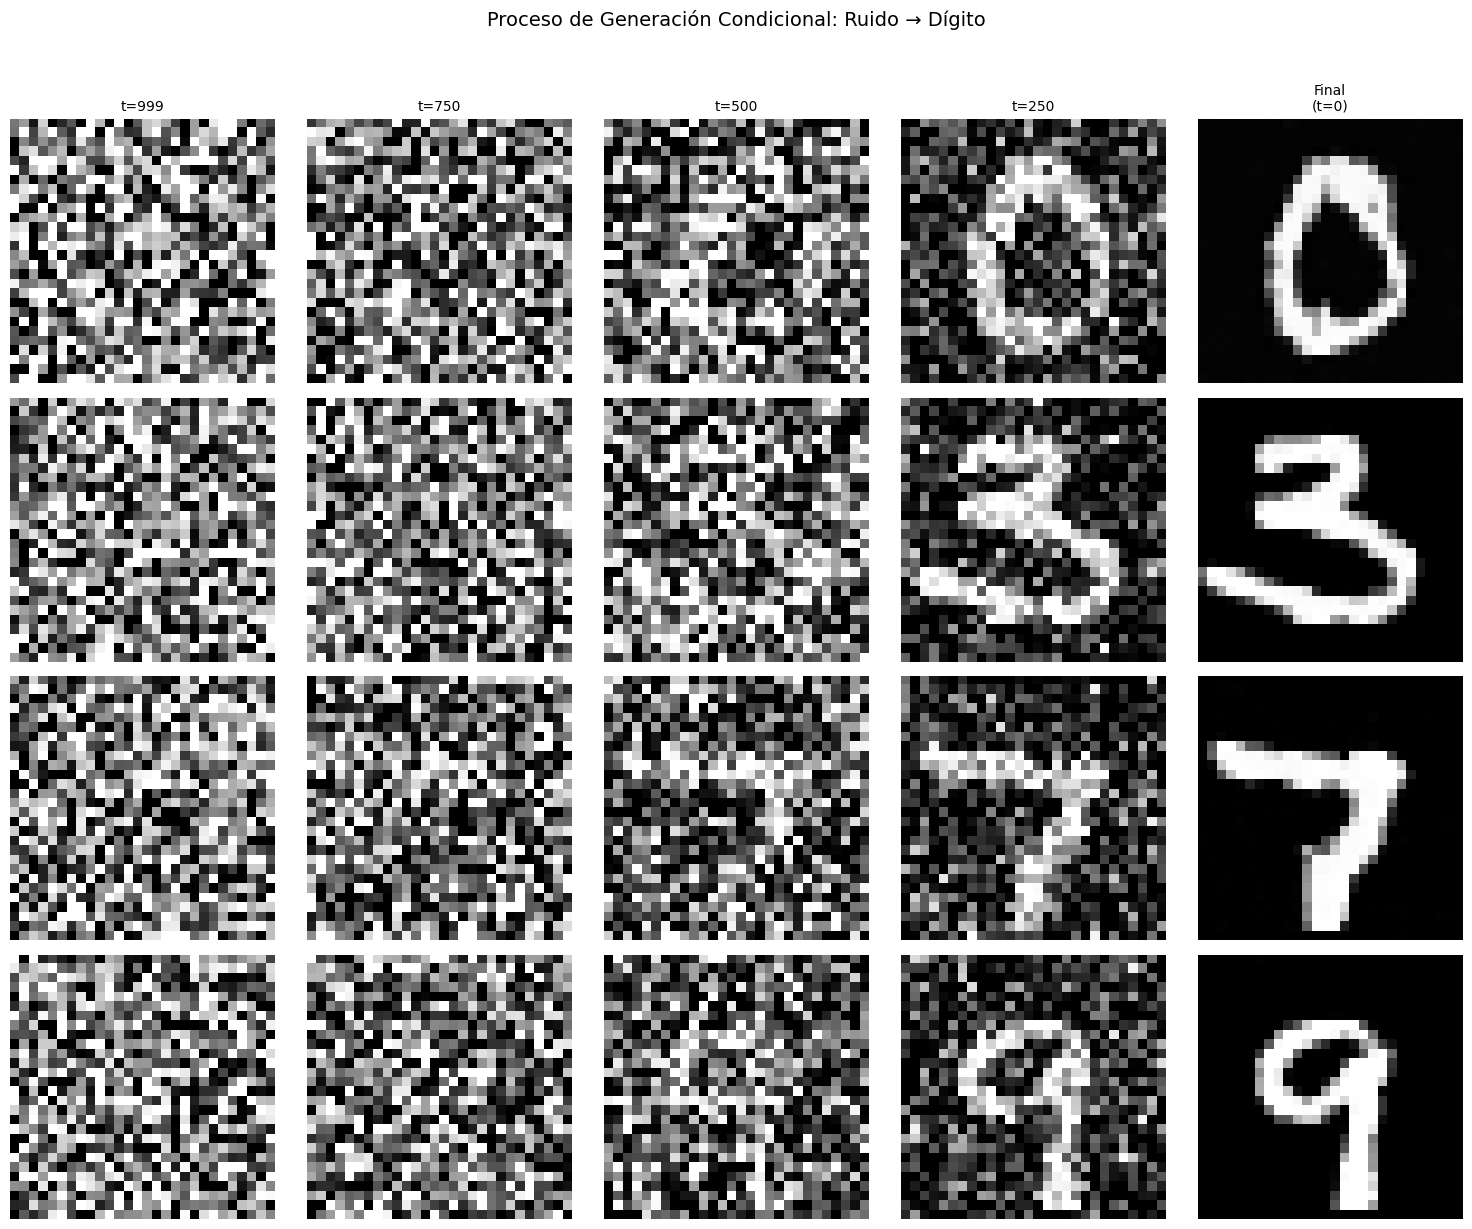

✨ Resultados Finales:


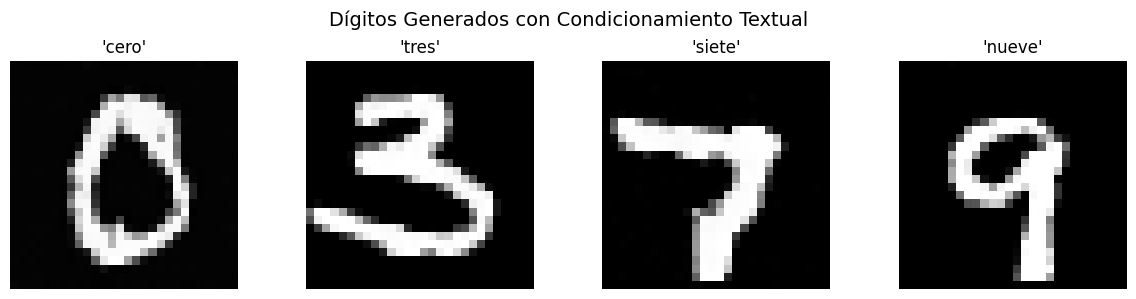


Condicional vs Incondicional


Generando con condicionamiento: 100%|██████████| 1000/1000 [00:07<00:00, 133.29it/s]
C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_8268\999639726.py:21: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  plt.tight_layout()
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


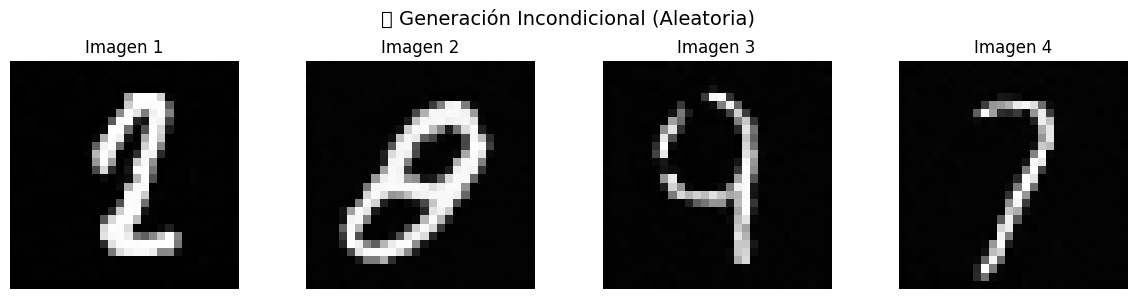


Diferentes niveles de Guidance


Generando con condicionamiento: 100%|██████████| 1000/1000 [00:11<00:00, 85.84it/s]


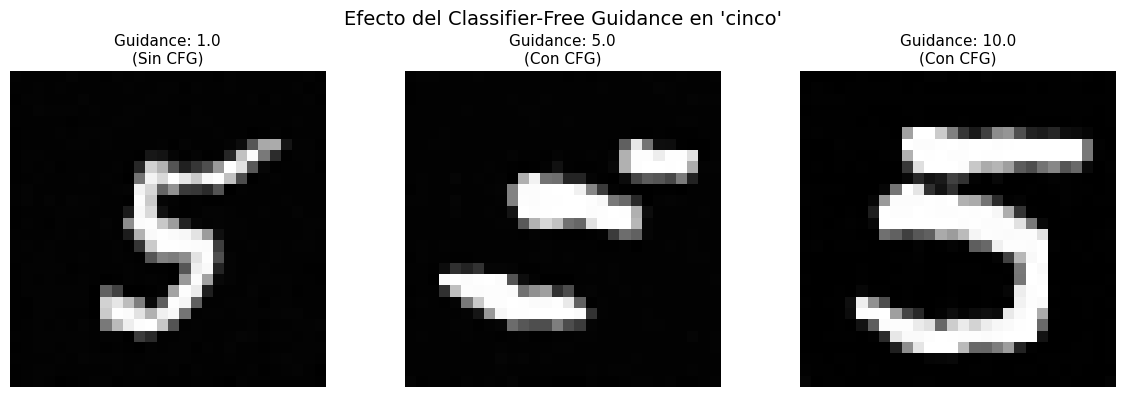

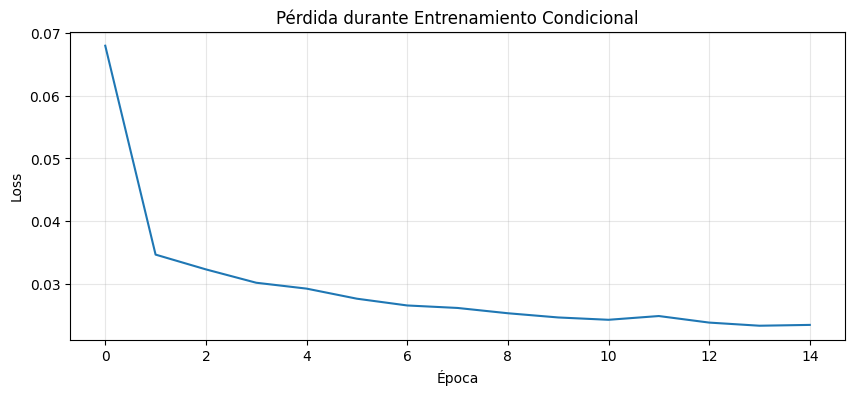

In [11]:
def plot_final_images(images, prompts=None, title="Imágenes Generadas"):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    if len(images) == 1:
        axes = [axes]
    
    for i, img in enumerate(images):
        img_np = img.cpu().numpy().squeeze()
        img_np = (img_np + 1) / 2
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np, cmap='gray')
        axes[i].axis('off')
        
        if prompts is not None:
            prompt_text = class_names[prompts[i]] if prompts[i] in class_names else f"Clase {prompts[i]}"
            axes[i].set_title(f"'{prompt_text}'", fontsize=12)
        else:
            axes[i].set_title(f'Imagen {i+1}', fontsize=12)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("Generación Condicional")
print("Generando dígitos específicos: 0, 3, 7, 9")

prompts_specific = [0, 3, 7, 9]
final_images, denoising_steps = conditional_sample_images(
    model, 
    prompts=prompts_specific, 
    n_samples=4, 
    guidance_scale=7.5,
    show_process=True
)

print("Proceso de Denoising (5 pasos):")
plot_denoising_process(denoising_steps, prompts_specific, "Proceso de Generación Condicional: Ruido → Dígito")

print("✨ Resultados Finales:")
plot_final_images(final_images, prompts_specific, "Dígitos Generados con Condicionamiento Textual")

print("\nCondicional vs Incondicional")

# Generar sin condicionamiento (aleatorio)
final_uncond = conditional_sample_images(model, prompts=None, n_samples=4, show_process=False)
plot_final_images(final_uncond, None, "🎲 Generación Incondicional (Aleatoria)")

print("\nDiferentes niveles de Guidance")

guidance_levels = [1.0, 5.0, 10.0]  # Sin guidance, medio, fuerte
prompts_test = [5, 5, 5]  # Mismo dígito con diferentes guidance

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, guidance in enumerate(guidance_levels):
    img_guided = conditional_sample_images(
        model, 
        prompts=prompts_test[i:i+1], 
        n_samples=1, 
        guidance_scale=guidance,
        show_process=False
    )
    
    img_np = img_guided[0].cpu().numpy().squeeze()
    img_np = (img_np + 1) / 2
    img_np = np.clip(img_np, 0, 1)
    
    axes[i].imshow(img_np, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Guidance: {guidance}\n({'Sin' if guidance == 1.0 else 'Con'} CFG)", fontsize=11)

plt.suptitle("Efecto del Classifier-Free Guidance en 'cinco'", fontsize=14)
plt.tight_layout()
plt.show()

# Mostrar progreso de entrenamiento
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Pérdida durante Entrenamiento Condicional')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()